<a href="https://colab.research.google.com/github/adampotton/Cognitive_AI_CW/blob/main/Q2D_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Centre bias attention mask, mimics the implicit attention paid to the centre of the visual field

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import time
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


### Define Model with Attention Layers

In [30]:
img_size_div4 = 45  # Image size

class CenterBiasAttentionLayer(nn.Module):
    def __init__(self, img_size, in_channels):
        super(CenterBiasAttentionLayer, self).__init__()
        self.img_size = img_size
        self.in_channels = in_channels

        # Create a static center bias mask
        y, x = torch.meshgrid(torch.linspace(-1, 1, img_size), torch.linspace(-1, 1, img_size))
        self.register_buffer("center_bias", torch.exp(-(x**2 + y**2) / 0.3))  # Gaussian falloff

    def forward(self, x):
        b, c, h, w = x.size()
        # Resize the center bias mask to match feature map size
        resized_bias = F.interpolate(self.center_bias[None, None, :, :], size=(h, w), mode='bilinear', align_corners=True)
        attention_mask = resized_bias.repeat(b, c, 1, 1)  # Repeat for batch and channels

        return x * attention_mask

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(16 * img_size_div4 * img_size_div4, 128)
        self.fc2 = nn.Linear(128, 3)
        self.attn1 = CenterBiasAttentionLayer(img_size // 2, 8)  # Attention after first pooling
        self.attn2 = CenterBiasAttentionLayer(img_size // 4, 16)  # Attention after second pooling

    def forward(self, x, attn_on=True):
        x = self.pool(torch.relu(self.conv1(x)))
        if attn_on:
            x = self.attn1(x)  # Apply center bias after the first layer
        x = self.pool(torch.relu(self.conv2(x)))
        if attn_on:
            x = self.attn2(x)  # Apply center bias after the second layer
        x = self.dropout(x)
        x = x.view(-1, 16 * img_size_div4 * img_size_div4)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


### Load and Edit Data

In [31]:
img_size = img_size_div4 * 4 # Define image size

train_transform = transforms.Compose([ # Define transformations for training
    transforms.Resize((img_size, img_size)),  # Resize images to the desired size
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally
    transforms.RandomRotation(degrees=4),   # Randomly rotate images by up to 15 degrees
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

test_transform = transforms.Compose([ # Define transformations for testing (no augmentation)
    transforms.Resize((img_size, img_size)),  # Resize images to the desired size
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Define paths to your train and test directories
train_dir = '/content/drive/MyDrive/Cognitive_AI/shoes/train'
test_dir = '/content/drive/MyDrive/Cognitive_AI/shoes/test'

batch_size = 20
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform) # Load datasets using ImageFolder
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Create DataLoader for batching
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Train the Model

In [32]:
lr = 0.0006 # Learning rate
num_epochs = 20 # Number of epochs for training

model = CNN() # Initialise a model
criterion = nn.CrossEntropyLoss()  # Loss function and optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
t = time.time() # Start timer
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader: # Loop through images and labels to train
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    time_elapsed = time.time() - t # Calculate time elapsed
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}, Time: {time_elapsed}")


Epoch 1/20, Loss: 1.1132, Accuracy: 0.3179, Time: 16.807798624038696
Epoch 2/20, Loss: 1.0895, Accuracy: 0.4037, Time: 31.647366523742676
Epoch 3/20, Loss: 1.0801, Accuracy: 0.4008, Time: 46.43542671203613
Epoch 4/20, Loss: 1.0624, Accuracy: 0.4599, Time: 61.338538646698
Epoch 5/20, Loss: 1.0403, Accuracy: 0.4993, Time: 76.92940878868103
Epoch 6/20, Loss: 1.0227, Accuracy: 0.4796, Time: 91.47542262077332
Epoch 7/20, Loss: 0.9981, Accuracy: 0.5063, Time: 106.04272079467773
Epoch 8/20, Loss: 0.9578, Accuracy: 0.5556, Time: 122.423898935318
Epoch 9/20, Loss: 0.9532, Accuracy: 0.5598, Time: 137.37043523788452
Epoch 10/20, Loss: 0.9112, Accuracy: 0.5752, Time: 152.21214151382446
Epoch 11/20, Loss: 0.8796, Accuracy: 0.6174, Time: 167.20097303390503
Epoch 12/20, Loss: 0.8455, Accuracy: 0.6006, Time: 182.04287910461426
Epoch 13/20, Loss: 0.7975, Accuracy: 0.6723, Time: 196.5168330669403
Epoch 14/20, Loss: 0.8311, Accuracy: 0.6315, Time: 212.2422914505005
Epoch 15/20, Loss: 0.7908, Accuracy: 0.

### Testing the Model

In [33]:
model.eval()  # Set model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # No need to track gradients during evaluation
    for images, labels in test_loader:
        output = model(images)
        _, predicted = torch.max(output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.5614


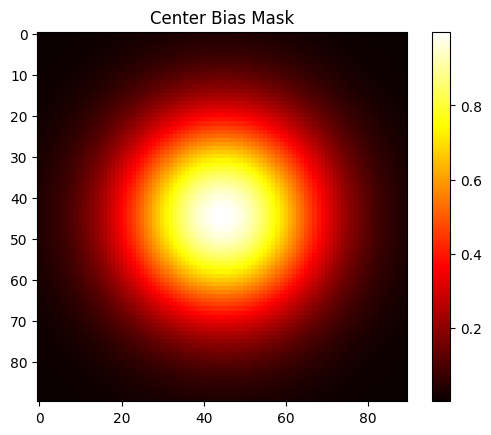

In [34]:
center_bias_mask = model.attn1.center_bias.cpu().numpy().squeeze()
plt.imshow(center_bias_mask, cmap='hot')
plt.title("Center Bias Mask")
plt.colorbar()
plt.show()
